チームわらわら　機械分析

In [5]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import  pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import missingno as msno

In [7]:
# CSVの読み込み
df = pd.read_csv("wwww_db.csv")

ピボット処理を行い、reception_idごとに1行にまとめるワイドフォーマットへの変換

In [12]:
df_wide_format = df.pivot_table(index="reception_id",
                                columns="question_id",
                                values=["answer_numeric", "answer_boolean", "answer_categorical"],
                                aggfunc="first")
# カラム名を整理（例: "q1_answer_numeric", "q2_answer_boolean" など）
df_wide_format.columns = [f"q{col[1]}_{col[0]}" for col in df_wide_format.columns]
df_wide_format.reset_index(inplace=True)

df_wide_format.head(20)

,reception_id,q2_answer_boolean,q3_answer_boolean,q5_answer_boolean,q6_answer_boolean,q1_answer_categorical,q4_answer_categorical,q7_answer_numeric,q8_answer_numeric,q9_answer_numeric,q10_answer_numeric,q11_answer_numeric,q12_answer_numeric
0,1000,0.0,1.0,1.0,0.0,1R / 1K,エリア設定,5.0,5.0,2.0,5.0,4.0,5.0
1,1001,0.0,0.0,1.0,0.0,3LDK以上,どちらも,5.0,1.0,2.0,4.0,5.0,5.0
2,1002,0.0,1.0,1.0,0.0,1R / 1K,エリア設定,3.0,5.0,3.0,3.0,2.0,4.0
3,1003,1.0,1.0,1.0,1.0,1LDK〜2LDK,どちらも,1.0,3.0,1.0,3.0,1.0,3.0
4,1004,1.0,0.0,0.0,0.0,1R / 1K,特になし,2.0,1.0,3.0,3.0,5.0,2.0
5,1005,0.0,0.0,1.0,1.0,1LDK〜2LDK,スケジュール設定,3.0,4.0,4.0,1.0,3.0,4.0
6,1006,1.0,0.0,0.0,1.0,1LDK〜2LDK,どちらも,1.0,1.0,5.0,1.0,2.0,1.0
7,1007,1.0,0.0,1.0,0.0,3LDK以上,特になし,2.0,4.0,4.0,1.0,3.0,4.0
8,1008,0.0,0.0,1.0,0.0,3LDK以上,どちらも,5.0,1.0,5.0,3.0,4.0,1.0
9,1009,1.0,0.0,0.0,1.0,1LDK〜2LDK,スケジュール設定,1.0,4.0,4.0,1.0,5.0,5.0


データの可視化を実行
単変量可視化

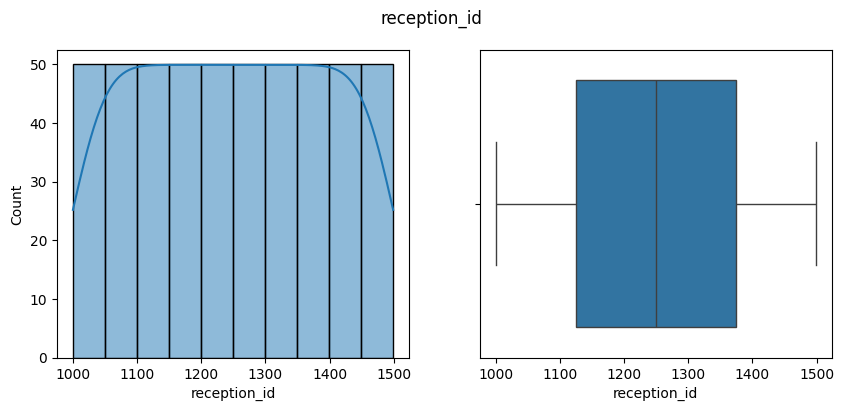

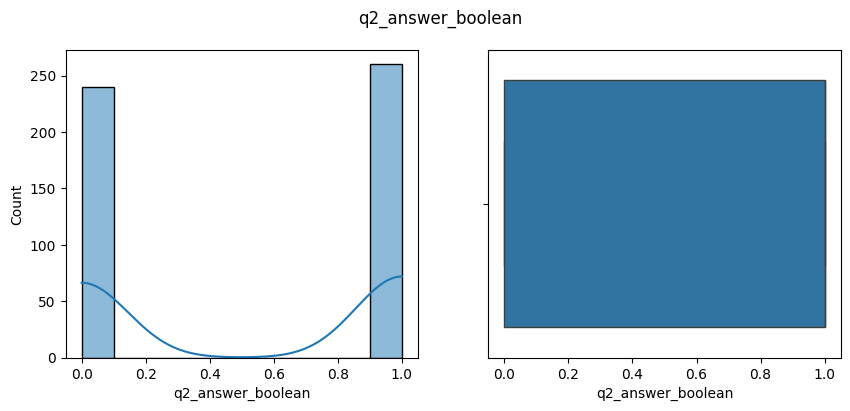

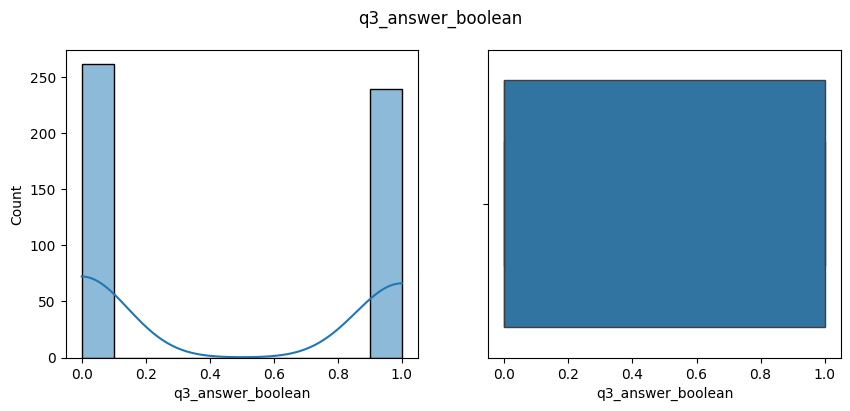

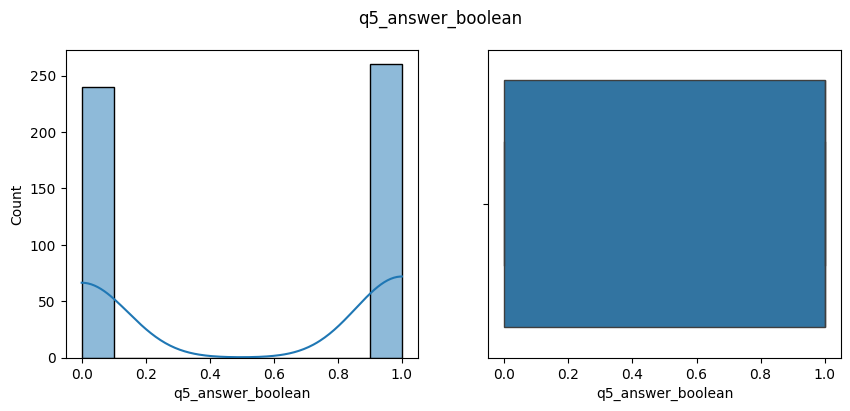

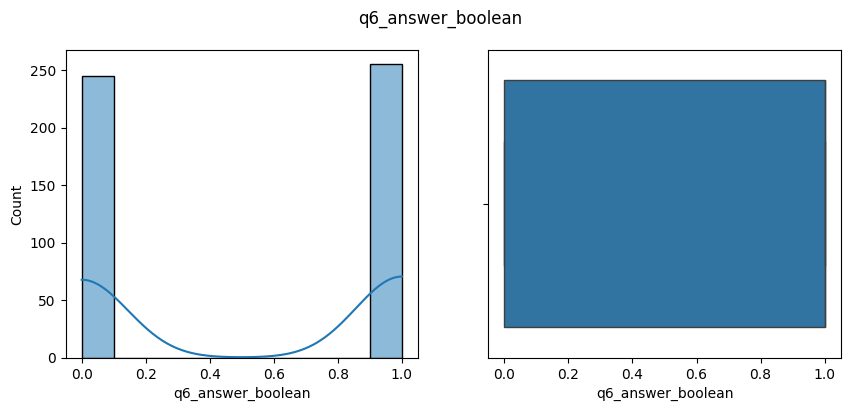

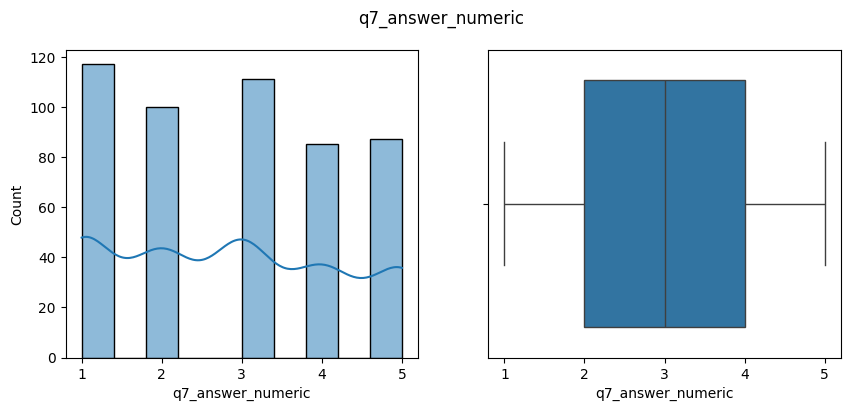

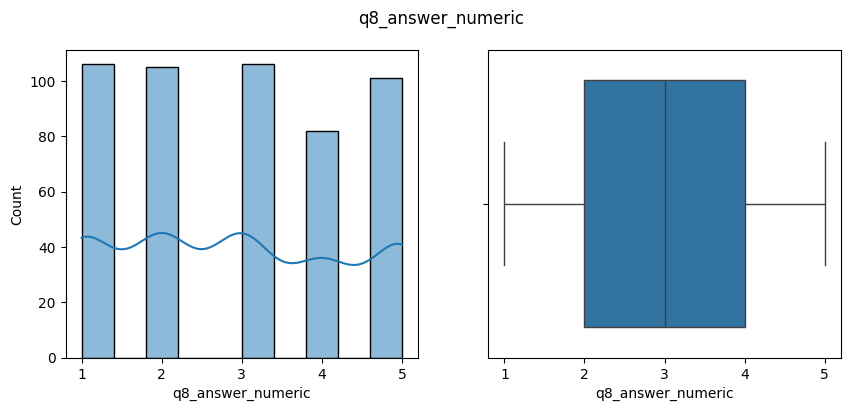

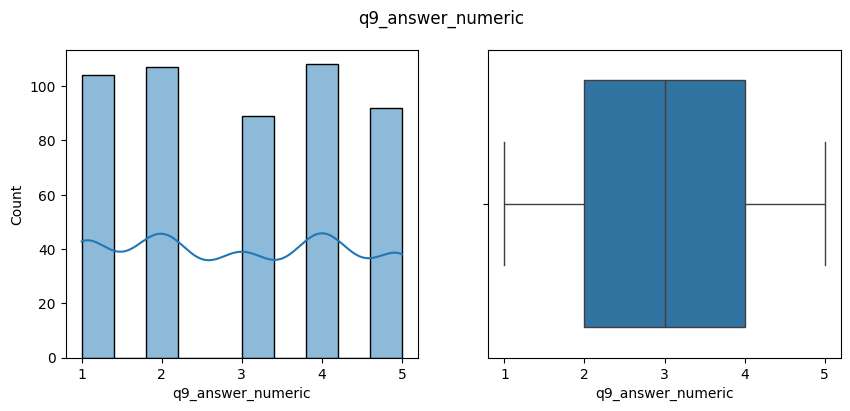

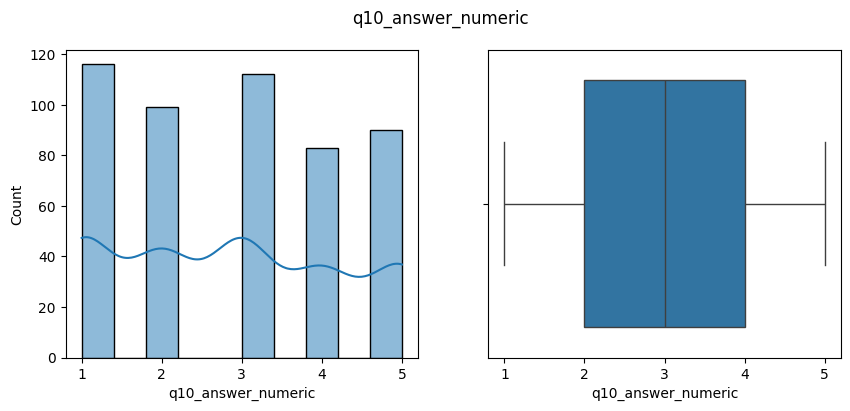

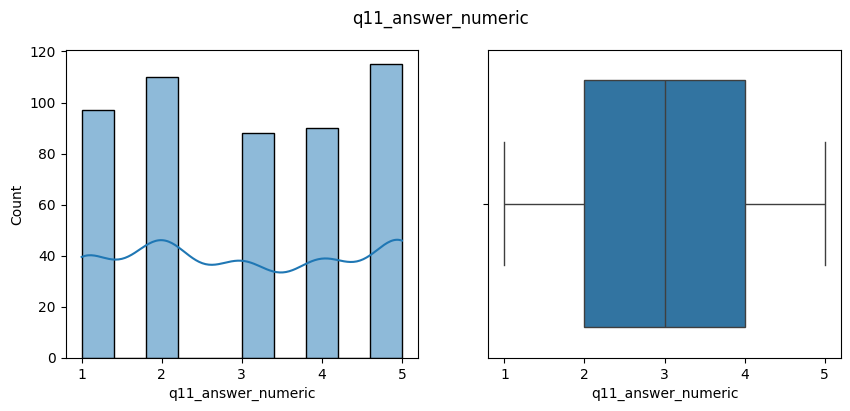

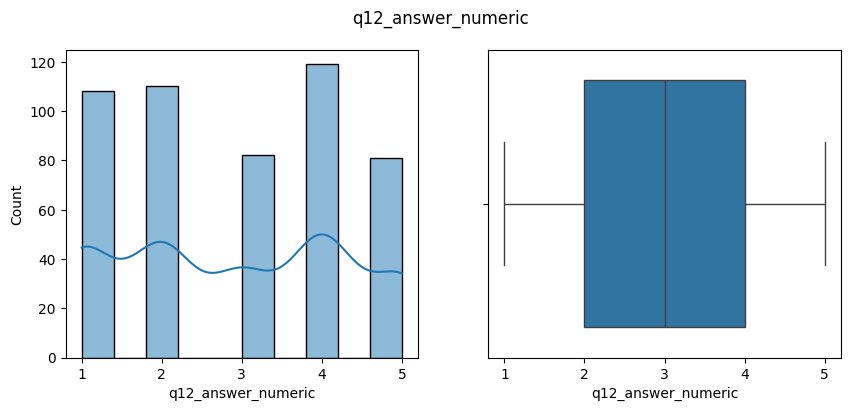

In [15]:
numeric_cols = df_wide_format.select_dtypes(include=['int64','float64']).columns
for col in numeric_cols:
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    sns.histplot(df_wide_format[col].dropna(), ax=axes[0], kde=True)
    sns.boxplot(x=df_wide_format[col], ax=axes[1])
    plt.suptitle(col)
    plt.show()

二変量可視化（相関ヒートマップ）


In [16]:
plt.figure(figsize=(8,6))
sns.heatmap(df_wide_format.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

ValueError: could not convert string to float: '1R / 1K'

<Figure size 800x600 with 0 Axes>

多変量可視化（PCA, t-SNE）
ワイドフォーマットのデータ（df_wide_format）から数値データだけを取り出し、欠損値のある行を除外した上で、PCAとt-SNEという次元削減手法を用いてデータを2次元に圧縮し、可視化

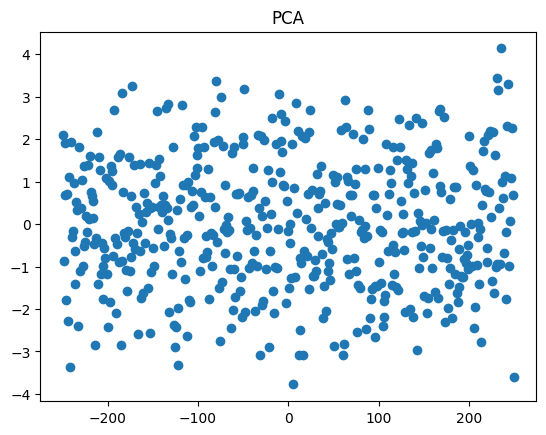

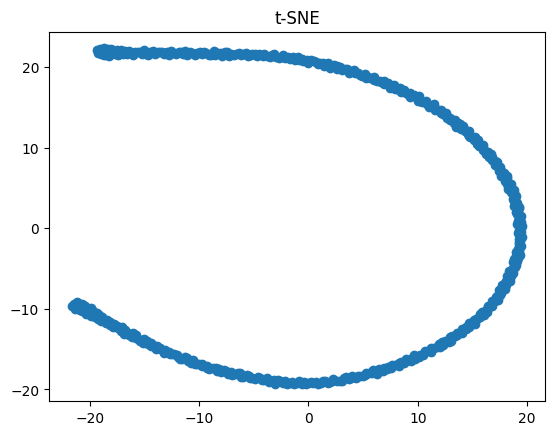

In [ ]:
# 数値型のカラムだけを抽出
df_num = df_wide_format.select_dtypes(include=['int64','float64']).dropna()

# PCA（主成分分析）を用いて、元の多次元データを2つの主成分に圧縮します。
# 得られた2次元のデータを散布図にプロットすることで、データ全体の大まかな構造や潜在的なクラスタが視覚的に確認できる
pca = PCA(n_components=2).fit_transform(df_num)
plt.scatter(pca[:,0], pca[:,1])
plt.title("PCA")
plt.show()

# t-SNE（t分布型確率的近傍埋め込み）は、局所的な構造をうまく保持する次元削減手法です。
# 同様に2次元に変換したデータを散布図にプロットし、細かなクラスタリングの兆候などを視覚的に把握
tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(df_num)
plt.scatter(tsne[:,0], tsne[:,1])
plt.title("t-SNE")
plt.show()

欠損可視化

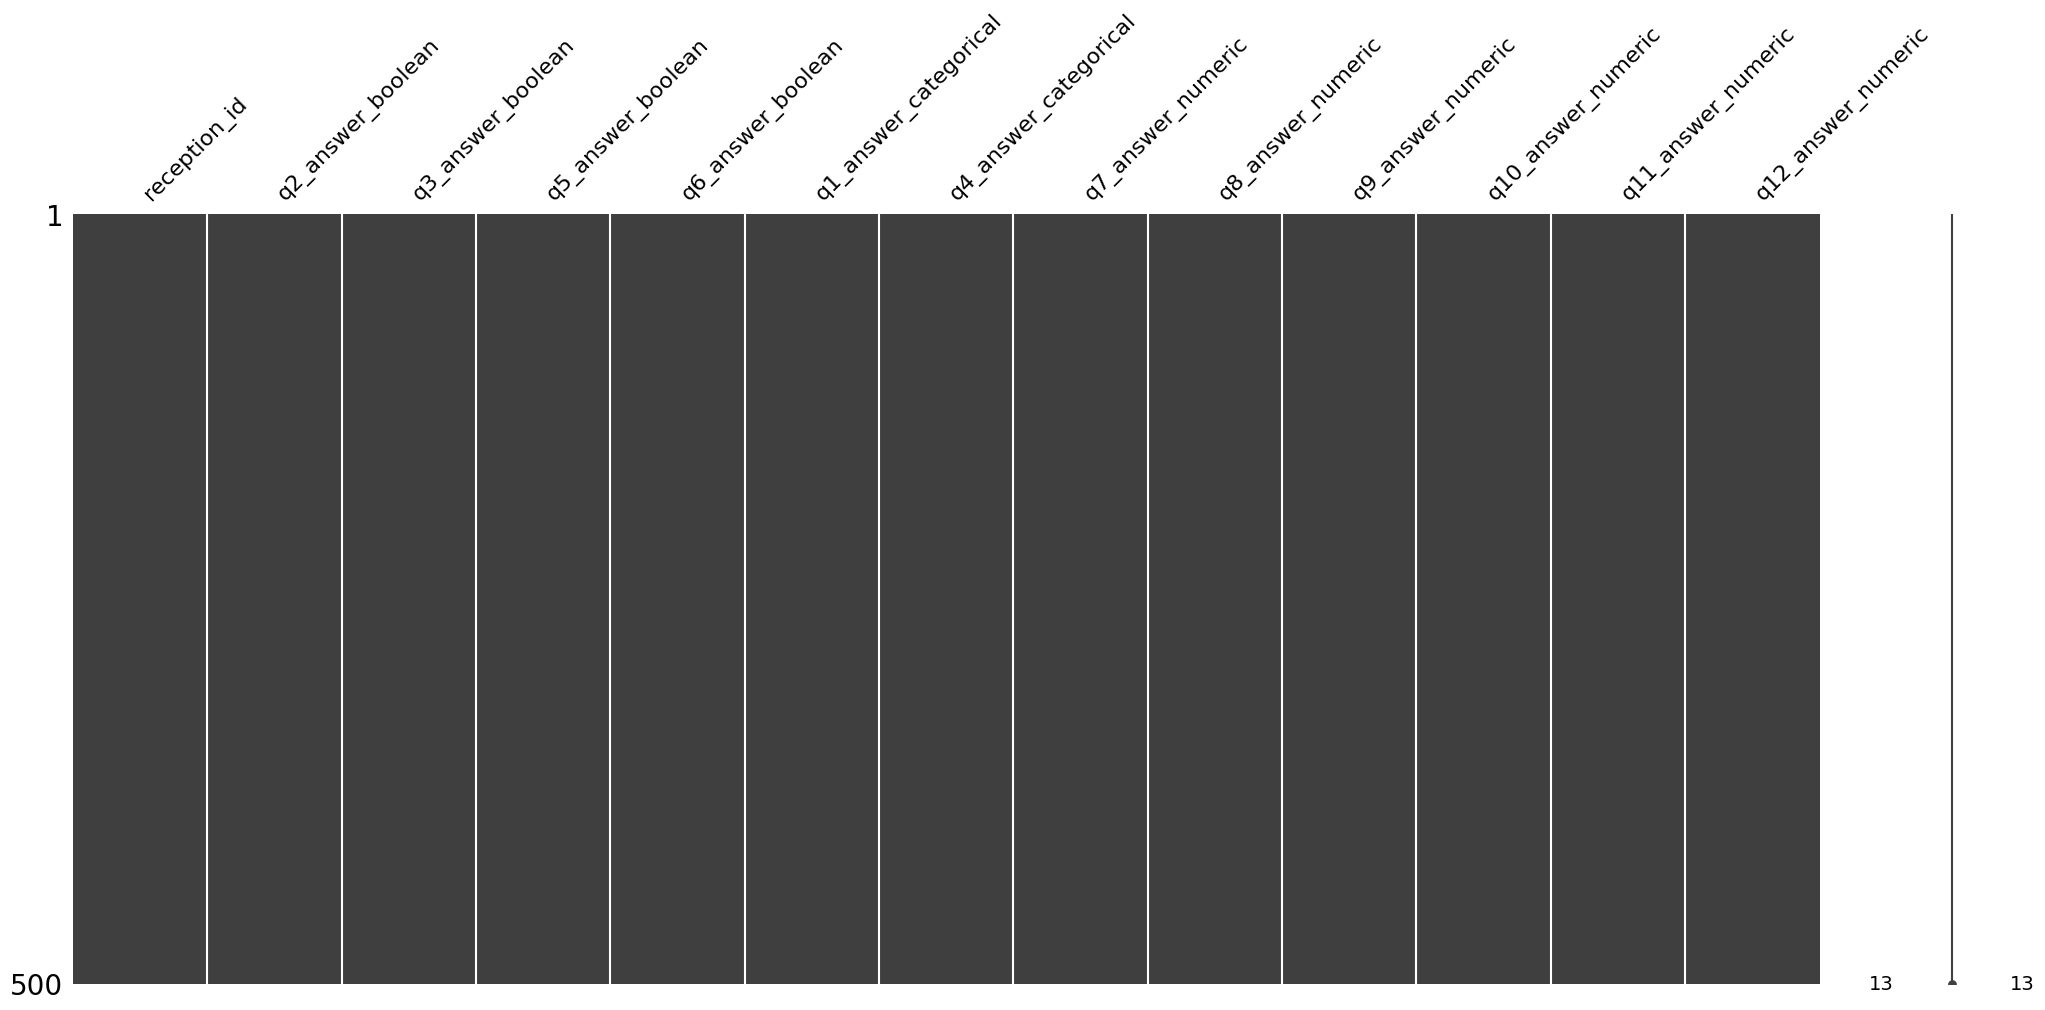

c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
c:\Users\堀江雅彦\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


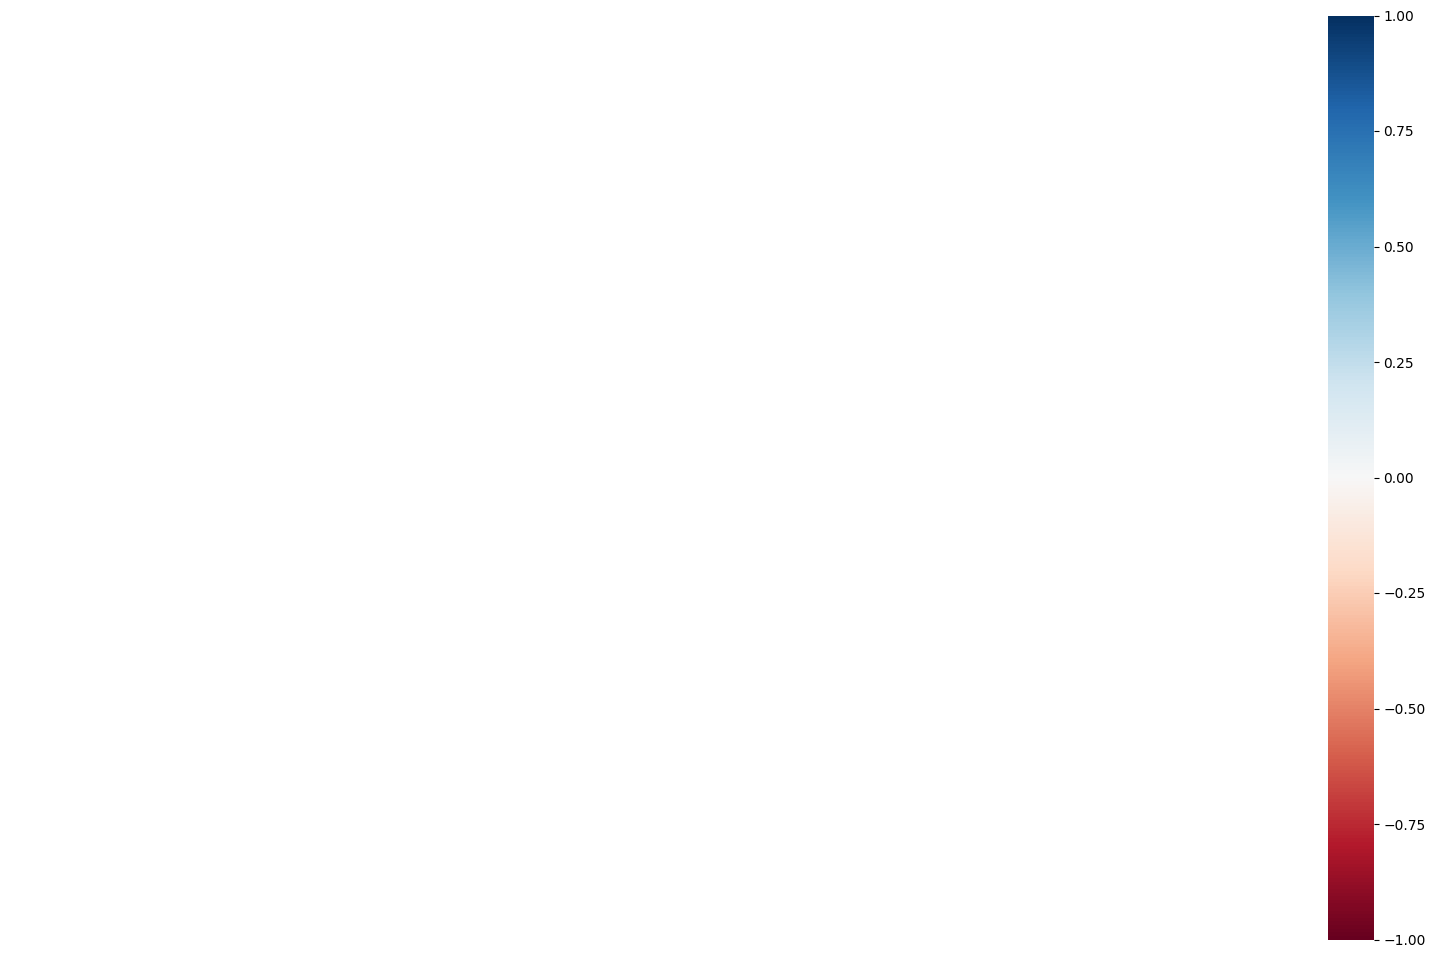

In [18]:
msno.matrix(df_wide_format)
plt.show()
msno.heatmap(df_wide_format)
plt.show()